In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [3]:
# 1. Helper Function to Load Data
def load_and_prep_data(filename):
    print(f"Loading {filename}...")
    # Read CSV without header (assuming your np.savetxt didn't add one)
    df = pd.read_csv(filename, header=None)
    
    # According to your structure: 
    # - Last column is Patient ID
    # - Second to last column is Class Label
    # - Everything else is the ECG Signal (features)
    
    X = df.iloc[:, :-2].values  # Signal
    y = df.iloc[:, -2].values   # Class Label
    patients = df.iloc[:, -1].values # Patient ID (kept for reference)
    
    return X, y, patients

# 2. Load all 4 datasets
# Beat Split Data
X_train_beat, y_train_beat, pat_train_beat = load_and_prep_data('./train_beats.csv')
X_test_beat, y_test_beat, pat_test_beat = load_and_prep_data('./test_beats.csv')

# Patient Split Data
X_train_pat, y_train_pat, pat_train_pat = load_and_prep_data('./train_patients.csv')
X_test_pat, y_test_pat, pat_test_pat = load_and_prep_data('./test_patients.csv')

print(f"\nBeat Split Train Shape: {X_train_beat.shape}")
print(f"Patient Split Train Shape: {X_train_pat.shape}")

Loading ./train_beats.csv...
Loading ./test_beats.csv...
Loading ./train_patients.csv...
Loading ./test_patients.csv...

Beat Split Train Shape: (30992, 275)
Patient Split Train Shape: (200352, 275)


In [4]:
def evaluate_model(y_true, y_pred, model_name):
    """
    Calculates and prints key metrics for the assignment.
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"--- {model_name} Results ---")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[1,2,3,4,5,6,7,8], 
                yticklabels=[1,2,3,4,5,6,7,8])
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return acc, f1

Training SVM on Beat Split data... (this may take a moment)
--- SVM (Beat Split) Results ---
Accuracy:  0.9384
Precision: 0.7629
Recall:    0.9527
F1 Score:  0.8151


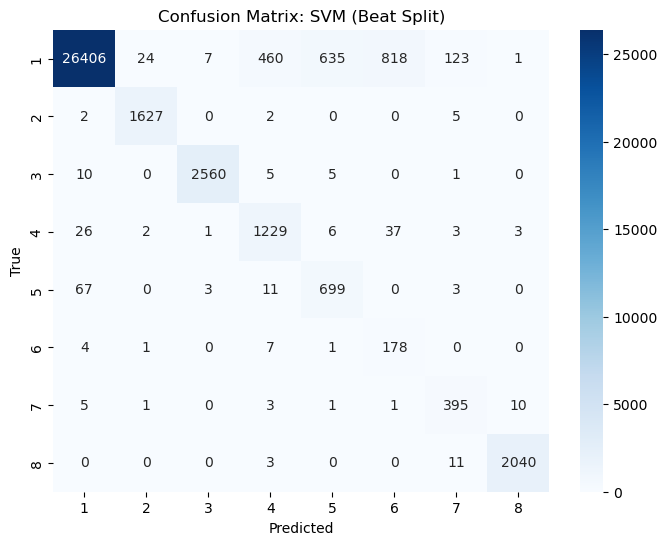

(0.9383579936969179, 0.815065591897361)

In [5]:
# Initialize SVM Classifier
svm_beat = SVC(kernel='rbf', probability=True, random_state=42)

print("Training SVM on Beat Split data... (this may take a moment)")
svm_beat.fit(X_train_beat, y_train_beat)

# Predict
y_pred_beat = svm_beat.predict(X_test_beat)

# Evaluate
evaluate_model(y_test_beat, y_pred_beat, "SVM (Beat Split)")

In [ ]:
# Initialize a fresh SVM
svm_pat = SVC(kernel='rbf', probability=True, random_state=42, max_iter=2000)

print("Training SVM on Patient Split data...")
svm_pat.fit(X_train_pat, y_train_pat)

# Predict on the held-out patients
y_pred_pat = svm_pat.predict(X_test_pat)
# Evaluate
evaluate_model(y_test_pat, y_pred_pat, "SVM (Patient Split)")

Training SVM on Patient Split data...


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

def run_permutation_importance(X, y, model_class, num_slices=11, n_splits=5):
    """
    Implements the PDF's specific Permutation Feature Importance with K-Fold CV.
    """
    
    # 1. Setup
    # Each heartbeat has 275 points. 275 / 11 slices = 25 points per slice.
    slice_size = X.shape[1] // num_slices 
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Matrix to store scores: [fold_index, slice_index]
    importance_matrix = np.zeros((n_splits, num_slices))
    
    print(f"Starting {n_splits}-Fold Permutation Importance on {num_slices} slices...")

    # 2. K-Fold Loop
    fold_idx = 0
    for train_index, val_index in skf.split(X, y):
        # Create the data for this specific fold
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        
        # A. Train a fresh model on this fold
        # We use probability=True because it's required for some advanced metrics, 
        # though accuracy relies on just the prediction.
        model = model_class(kernel='rbf', probability=True, random_state=42)
        model.fit(X_train_fold, y_train_fold)
        
        # B. Get baseline accuracy (Clean Data)
        baseline_pred = model.predict(X_val_fold)
        baseline_acc = accuracy_score(y_val_fold, baseline_pred)
        
        # C. Slice Loop: Corrupt one slice at a time and re-test
        for slice_i in range(num_slices):
            # Create a copy of validation data to mess with
            X_val_permuted = X_val_fold.copy()
            
            # Define the start/end columns for this slice (e.g., 0-25, 25-50)
            start_col = slice_i * slice_size
            end_col = start_col + slice_size
            
            # PERTURBATION: Randomly shuffle values within this slice for every row
            # This destroys the pattern in just this specific time window.
            for row in range(X_val_permuted.shape[0]):
                np.random.shuffle(X_val_permuted[row, start_col:end_col])
                
            # Predict with corrupted data
            permuted_pred = model.predict(X_val_permuted)
            permuted_acc = accuracy_score(y_val_fold, permuted_pred)
            
            # Importance = Baseline Accuracy - Corrupted Accuracy
            # If accuracy dropped from 90% to 60%, importance is 0.30 (High)
            # If accuracy dropped from 90% to 89%, importance is 0.01 (Low)
            importance = baseline_acc - permuted_acc
            importance_matrix[fold_idx, slice_i] = importance
        
        print(f"Fold {fold_idx+1}/{n_splits} complete.")
        fold_idx += 1

    # 3. Average over all folds to get final robust scores
    mean_importance = np.mean(importance_matrix, axis=0)
    return mean_importance

# --- EXECUTION ---
# We run this on the 'Beat Split' training data (X_train_beat) because 
# it is balanced and stable, making it ideal for feature analysis.
print("Running Feature Importance Analysis... (This involves retraining 5 times, please wait)")
feature_importance_scores = run_permutation_importance(X_train_beat, y_train_beat, SVC)

# 4. Visualization
plt.figure(figsize=(10, 6))
plt.bar(range(1, 12), feature_importance_scores, color='darkorange', edgecolor='black')
plt.title("Average Feature Importance per ECG Slice (SVM)")
plt.xlabel("ECG Slice (1 = Start of Beat, 11 = End of Beat)")
plt.ylabel("Drop in Accuracy (Importance)")
plt.xticks(range(1, 12))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()